# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### Importing Libraries

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import arma_order_select_ic
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data = data.resample('1H').sum()

## Analysis

### Determining Missing Values

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [4]:
missing_values = data.isna().sum()[0]
print(f"There are {missing_values} missing values in this Dataframe.")

There are 0 missing values in this Dataframe.


### Trend, Seasonal and Residual Plots

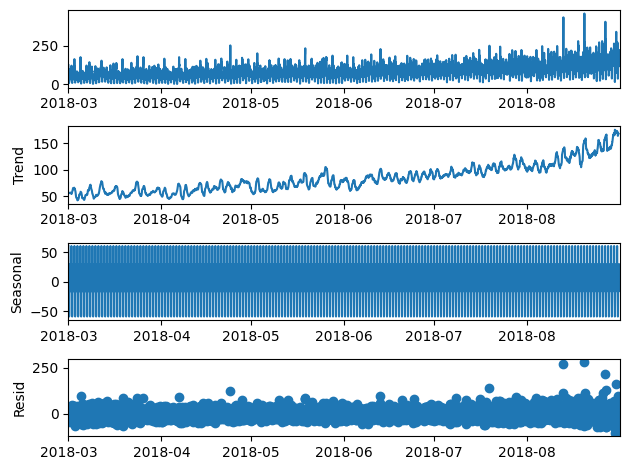

In [5]:
decomposition = seasonal_decompose(data)

decomposition.plot()
plt.show()

### Plotting 7 Day Cycle

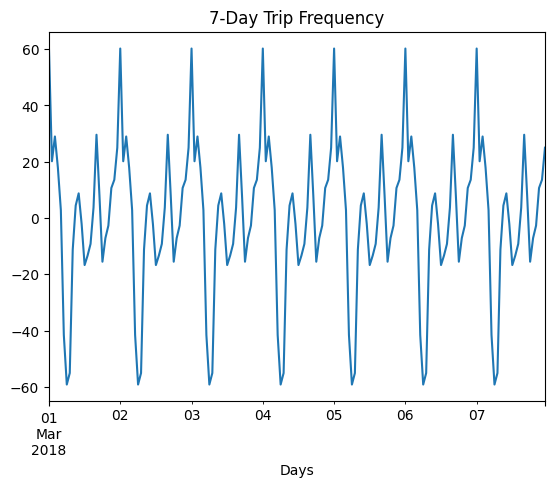

In [6]:
Days = 7
hours_in_day = 24
hours_in_period = Days * hours_in_day
decomposition.seasonal[0:hours_in_period].plot()
plt.title("7-Day Trip Frequency")
plt.xlabel("Days")
plt.show()

By looking at the plot for 7 days, you can see that the day starts off at 0 taxi orders and it increases the demand for taxis towards the middle of the day and it reaches its all time high at the end of the day. This trend is the same everyday of the week in the plot created.

### Defining to See if Data is Stationary or Non-Stationary

In [7]:
train, test = train_test_split(data, shuffle=False, test_size=.10, random_state=10)

In [8]:
data_stationary_test = adfuller(train, autolag='AIC')
print("P-Value:", data_stationary_test[1])

P-Value: 0.0007322730527364293


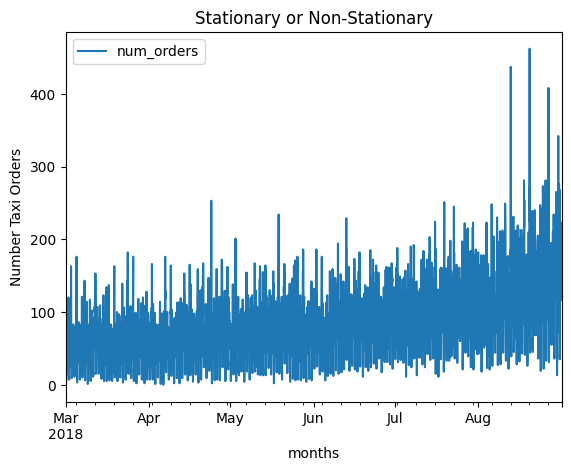

In [9]:
data.plot()
plt.title("Stationary or Non-Stationary")
plt.xlabel("months")
plt.ylabel('Number Taxi Orders')
plt.show()

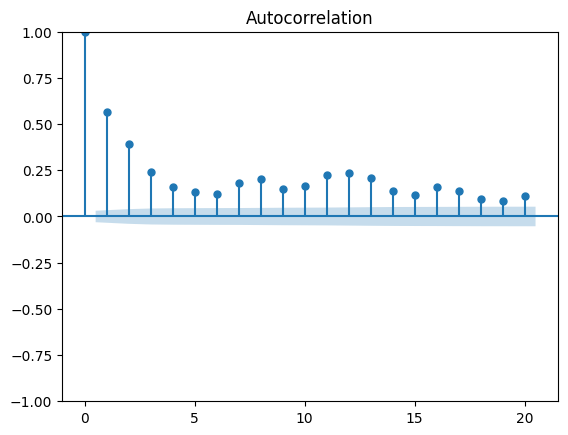

In [10]:
acf = plot_acf(x=train, lags=20)

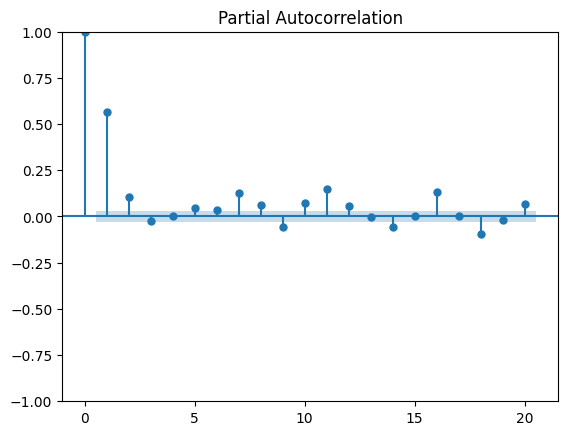

In [11]:
pacf = plot_pacf(x=train, lags=20)

By looking at the P-Value and seeing the plot visualization, you can determine that the dataset is in fact stationary.

ACF shows significant autocorrelation for several lags, indicating that the time series is not random and past values significantly influence future values.  
  
PACF shows that the series has a strong lag 1 relationship; beyond that, the additional lags have reduced and mostly insignificant correlations.

## Training

In [12]:
data['rolling_mean'] = data['num_orders'].rolling(5).mean()

data['y_lag1'] = data['num_orders'].shift(1)
data['y_lag2'] = data['num_orders'].shift(2)
data['y_lag3'] = data['num_orders'].shift(3)

data.dropna(inplace=True)
data

,num_orders,rolling_mean,y_lag1,y_lag2,y_lag3
datetime,,,,,
2018-03-01 04:00:00,43,77.8,66.0,71.0,85.0
2018-03-01 05:00:00,6,54.2,43.0,66.0,71.0
2018-03-01 06:00:00,12,39.6,6.0,43.0,66.0
2018-03-01 07:00:00,15,28.4,12.0,6.0,43.0
2018-03-01 08:00:00,34,22.0,15.0,12.0,6.0
...,...,...,...,...,...
2018-08-31 19:00:00,136,174.6,207.0,217.0,197.0
2018-08-31 20:00:00,154,182.2,136.0,207.0,217.0
2018-08-31 21:00:00,159,174.6,154.0,136.0,207.0


### AR Model

In [13]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=.1, random_state=10)

In [15]:
ar_mod = ar_select_order(endog=train, maxlag=40)
ar_order = ar_mod.ar_lags
print(f"Lags that define AR Model: {ar_order}")

Lags that define AR Model: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


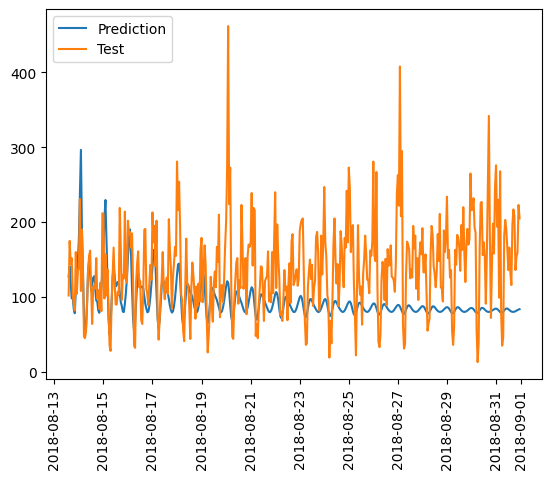

In [16]:
ar_model = AutoReg(train, lags=ar_order)
ar_model = ar_model.fit()
start_value = len(train)
end_value = len(train) + len(test) - 1
ar_predict= ar_model.predict(start=start_value, end=end_value, dynamic=False)
plt.plot(ar_predict, label="Prediction")
plt.plot(test, label="Test")
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

In [17]:
mse_ar = mean_squared_error(ar_predict, y_valid)
rsme_ar = np.sqrt(mse_ar)
print(f"AR Model RSME: {rsme_ar:.2f}")

AR Model RSME: 54.30


In [18]:
print(f""" After introducing new features to the data, the rolling mean, lag1, lag2, and lag3,
and creating a Autoregressive model, the result for the Root Mean Squared Error is {rsme_ar:.2f}. The acceptable RMSE 
is under 48, this is not a good model to use for our machine learning model.
""")

 After introducing new features to the data, the rolling mean, lag1, lag2, and lag3,
and creating a Autoregressive model, the result for the Root Mean Squared Error is 54.30. The acceptable RMSE 
is under 48, this is not a good model to use for our machine learning model.



### ARIMA (Autoregressive Integrate Moving Average Model

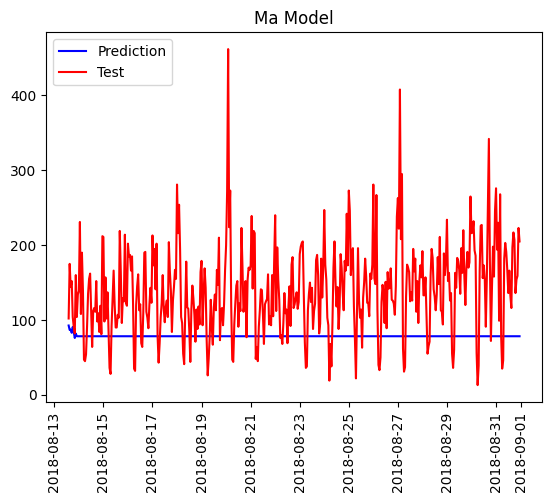

In [19]:
residuals = arma_order_select_ic(y=train, max_ar=0, max_ma=10)
ma_order = residuals.bic_min_order[1]
ma_model = ARIMA(train, order=(0, 0, ma_order))
ma_model = ma_model.fit()
start_ma = len(train)
end_ma = len(train) + len(test) - 1
ma_pred = ma_model.predict(start=start_ma, end=end_ma, dynamic=False)

plt.plot(ma_pred, color='blue', label='Prediction')
plt.plot(test, color='red', label='Test')
plt.title("Ma Model")
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.show()

In [20]:
mse_ma = mean_squared_error(ma_pred, y_valid)
rsme_ma = np.sqrt(mse_ma)
print(f"MA Model RSME: {rsme_ma:.2f}")

MA Model RSME: 48.43


In [21]:
print(f"""
After creating a Moving Average model using the same data, we were able to output a RMSE of {rsme_ma:.2f}, 
a better result than the Autoregressive model.
""")


After creating a Moving Average model using the same data, we were able to output a RMSE of 48.43, 
a better result than the Autoregressive model.



### Linear Regression

In [22]:
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
y_prediction_linear = model_linear.predict(X_valid)
mse_linear = mean_squared_error(y_prediction_linear, y_valid)
rmse_linear = np.sqrt(mse_linear)
print(f"Linear Regression RMSE: {rmse_linear:.2f}")


Linear Regression RMSE: 25.61


In [23]:
print(f"""
Out of the models created, the Linear Regression model is the best model thus far, with a result of {rmse_linear:.2f}, 
much better outcome than the MA model and AR model.
""")


Out of the models created, the Linear Regression model is the best model thus far, with a result of 25.61, 
much better outcome than the MA model and AR model.



### Decision Tree Regression

In [24]:
model_decisionTree = DecisionTreeRegressor(max_depth=3, min_samples_split=5)
model_decisionTree.fit(X_train, y_train)
decisiontree_y_pred = model_decisionTree.predict(X_valid)
mse_decisionTree = mean_squared_error(decisiontree_y_pred, y_valid)
rsme_decisionTree = np.sqrt(mse_decisionTree)
print(f"Decision Tree RMSE: {rsme_decisionTree:.2f}")

Decision Tree RMSE: 36.55


In [25]:
print(f"""While taking into consideration the Decision Tree Regression model, the outcome of this model is
      {rsme_decisionTree:.2f}, not as accurate as a Linear Regression but still an acceptable model.""")

While taking into consideration the Decision Tree Regression model, the outcome of this model is
      36.55, not as accurate as a Linear Regression but still an acceptable model.


### Random Forest Regressor

In [26]:
random_forest = RandomForestRegressor(n_estimators=300, max_depth=1, min_samples_split=5)
random_forest.fit(X_train, y_train)
y_pred_random = random_forest.predict(X_valid)
mse_forest = mean_squared_error(y_pred_random, y_valid)
rmse_forest = np.sqrt(mse_forest)
print(f"RMSE Random Forest: {rmse_forest:.2f}")

RMSE Random Forest: 40.42


#### Random Forest with Different Hyperparametes

In [27]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [1, 2, 3],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10]  # Minimum samples required to split a node
}

tscv = TimeSeriesSplit(n_splits=5)  # Adjust n_splits as needed

grid_search = GridSearchCV(estimator=RandomForestRegressor(), param_grid=param_grid, cv=tscv)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best RMSE:", grid_search.best_score_)

best_model = grid_search.best_estimator_

y_pred_best = best_model.predict(X_valid)
mse_best = mean_squared_error(y_pred_best, y_valid)
rmse_best = np.sqrt(mse_best)
print(f"RMSE Best Random Forest: {rmse_best:.2f}")


Best Parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best RMSE: 0.5183152102509394
RMSE Best Random Forest: 33.36


In [28]:
print(f"""
While experimenting with the Randome Forest Regression model, and trying out different hyperparameters,
this model is best with the following parameters: {grid_search.best_params_}, resulting as the best RMSE of {rmse_best:.2f}
""")


While experimenting with the Randome Forest Regression model, and trying out different hyperparameters,
this model is best with the following parameters: {'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 300}, resulting as the best RMSE of 33.36



### ARMA (Autoregressive Moving Average Model)

/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[]

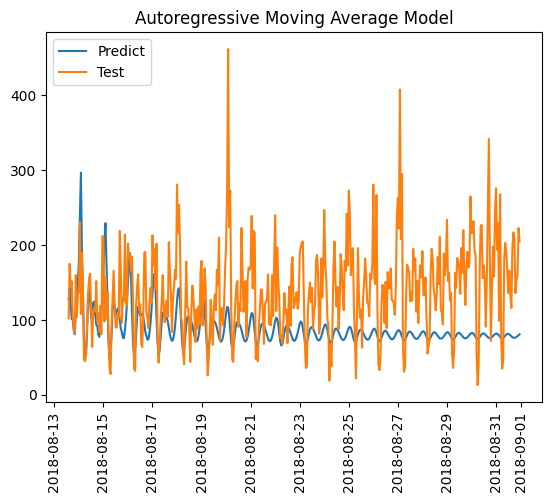

In [29]:
ar_order_arma = 28
ma_order_arma = 5
arma_full_order = (ar_order_arma, 0, ma_order_arma)

arma_model = ARIMA(train, order=arma_full_order)
arma_model = arma_model.fit()

start_arma = len(train)
end_arma = len(train) + len(test) - 1
arma_predict = arma_model.predict(start=start_arma, end=end_arma, dynamic=False)

plt.plot(arma_predict, label='Predict')
plt.plot(test, label='Test')
plt.xticks(rotation=90)
plt.title("Autoregressive Moving Average Model")
plt.legend(loc='upper left')
plt.plot()

In [30]:
mse_arma = mean_squared_error(arma_predict, y_valid)
rsme_arma = np.sqrt(mse_arma)
print(f"RSME: {rsme_arma:.2f}")

RSME: 53.99


## Testing

In [31]:
model_decisionTree = DecisionTreeRegressor(max_depth=1, min_samples_split=5, min_samples_leaf=4, max_features='auto')
model_decisionTree.fit(X_train, y_train)
decisiontree_y_pred = model_decisionTree.predict(X_valid)
mse_decisionTree = mean_squared_error(decisiontree_y_pred, y_valid)
rsme_decisionTree = np.sqrt(mse_decisionTree)
print(f"Decision Tree RMSE: {rsme_decisionTree:.2f}")

Decision Tree RMSE: 41.39


In [32]:
mse_linear_test = mean_squared_error(y_prediction_linear, y_valid)
rmse_linear_test = np.sqrt(mse_linear_test)
print(f"RMSE: {rmse_linear_test:.2f}")

RMSE: 25.61


In [33]:
print(f"""While using a Linear Regression model, you can see by the visual and the RMSE that this model is
the most accurate of the models created with a RMSE of {rmse_linear_test:.2f}, while the visuals are almost identical.""")

While using a Linear Regression model, you can see by the visual and the RMSE that this model is
the most accurate of the models created with a RMSE of 25.61, while the visuals are almost identical.


## Conclusion

In this project, first we had to analyze the data and see if the data provided was stationary or non-stationary. After deciding that the data was stationary, we went along a created different machine learning models, including: Decision Tree Regressor, Lienar Regression, Moving Average model and a Autoregression model for the time series. After creating different machine learning models and splitting up the data into training and test set, the best machine learning model for this type of series is the Linear Regression Model with a RMSE of 24.71. 